# **D3.1 DAS Data Processing**

**Algorithms for conversion/processing Distributed Acoustic Sensing (DAS) data. Computational scripts (Python, Matlab) for reading raw strain data from DAS interrogator, quality control, filtering, and organizing in strain(-rate)-time matrices for further use.**

This notebook provides a basic tutorial to estimate the Power Spectrum Density (PSD) and to apply a f−k filter with functions from the xDAS library. The data used is from the repository http://piweb.ooirsn.uw.edu/das24/data/ (2024 DAS data offshore Central Oregon).

In [ ]:
!pip install xdas  # this will install the xdas library
import xdas as xd
import numpy as np
import xdas.signal as xs
import xdas.fft as xfft
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import scipy.signal as sp
from skimage.draw import polygon
from scipy.ndimage import gaussian_filter
import scipy.fft
import h5py
import hdf5plugin

### **1. Download and read the $\texttt{.hdf5}$ files** (to be executed on your computer, not within colab)

In [3]:
!mkdir -p data

!wget -P data http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000005.hdf5
!wget -P data http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000015.hdf5
!wget -P data http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000025.hdf5
!wget -P data http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000035.hdf5

--2025-06-12 15:30:03--  http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000005.hdf5
Resolving piweb.ooirsn.uw.edu (piweb.ooirsn.uw.edu)... 140.142.14.75
Connecting to piweb.ooirsn.uw.edu (piweb.ooirsn.uw.edu)|140.142.14.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76454008 (73M) [application/octet-stream]
Saving to: ‘data/000005.hdf5.3’

000005.hdf5.3       100%[===================>]  72.91M  16.7MB/s    in 5.3s    

2025-06-12 15:30:08 (13.7 MB/s) - ‘data/000005.hdf5.3’ saved [76454008/76454008]

--2025-06-12 15:30:09--  http://piweb.ooirsn.uw.edu/das24/data/20240507/dphi/000015.hdf5
Resolving piweb.ooirsn.uw.edu (piweb.ooirsn.uw.edu)... 140.142.14.75
Connecting to piweb.ooirsn.uw.edu (piweb.ooirsn.uw.edu)|140.142.14.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76454008 (73M) [application/octet-stream]
Saving to: ‘data/000015.hdf5.3’

000015.hdf5.3       100%[===================>]  72.91M  19.3MB/s    in 4.8s    

2025

Data are archived through Ocean Observatory Initiative (OOI) Regional Cabled Array (RCA) and may be accessed at http://piweb.ooirsn.uw.edu/das24/. The files used here are in the folder "data/20240507/dphi/" from 000005.hdf5 to 000155.hdf5.

In [4]:
import glob

# Get the list of HDF5 files in the data/ directory
files = sorted(glob.glob("data/*.hdf5"))

# Open the files as a multi-file DataArray
da = xd.open_mfdataarray(files, engine='asn')
print(da)

<xdas.DataArray (time: 8000, distance: 9500)>
VirtualStack: 289.9MB (float32)
Coordinates:
  * time (time): 2024-05-07T00:00:05.302 to 2024-05-07T00:00:45.297
  * distance (distance): 0.000 to 97013.305


### **2. Visualization**

Plotting your DataArray is a one line job:

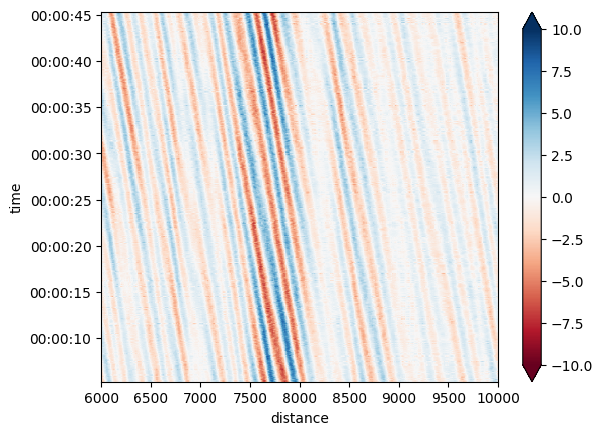

In [ ]:
da_red = da.sel(distance=slice(0, 10000))
da_red.plot(vmin=-10, vmax=10, cmap='RdBu', xlim=(6000, 10000))

### **3. Estimation of the PSD**

First, look at the number of samples $N$ and the sample frequency $f_\text{s}$ for normalizing:

In [6]:
N = da.shape[0]                                #number of samples in the first dimension ('time')
dt = xs.get_sampling_interval(da, "time")      #time sampling interval in seconds
dx = xs.get_sampling_interval(da, "distance")  #distance sampling interval in meters
fs = 1 / dt                                    #sample frequency in Hertz
print('Sample frequency [Hz]:', fs)
print('Nyquist frequency [Hz]:', fs/2)

Sample frequency [Hz]: 200.0
Nyquist frequency [Hz]: 100.0


Here how to estimate the PSD with funcions from $\texttt{xDAS}$ and the comparison with the $\texttt{periodogram}$ function from $\texttt{scipy.signal}$:

In [7]:
temporal_trace = da.sel(distance=41883.5, method='nearest') #choose one channel

PSD = xs.taper(temporal_trace, window='hann', dim='time')   #tappering
PSD = xfft.rfft(PSD, dim={"time": "frequency"})             #rename "time" -> "frequency"
PSD = (np.abs(PSD))**2 / (N * fs)                           #PSD with xDAS functions

freqs1, Pxx1 = periodogram(temporal_trace, fs=fs, scaling='density', window='hann') #PSD with scipy functions

As the $\texttt{periodogram}$ function normalises with other scalar factor, the plots have a constant shift:

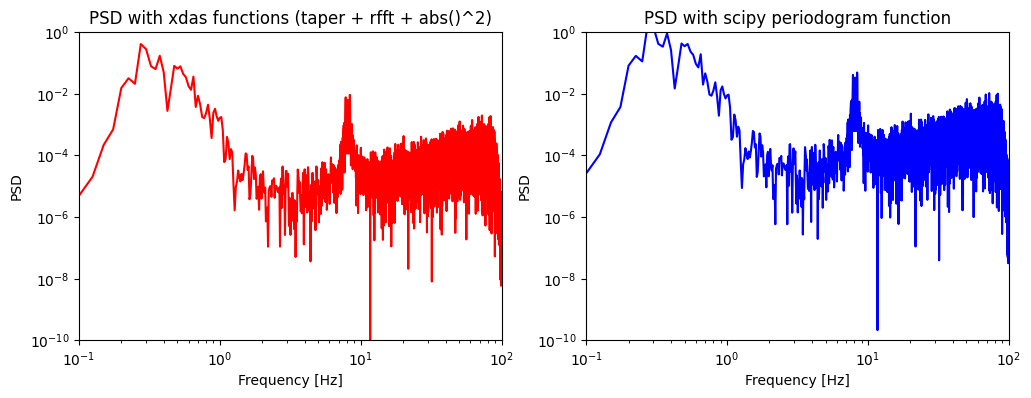

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(PSD.coords['frequency'], PSD, color='red'); axs[1].plot(freqs1, Pxx1, color='blue')
axs[0].set_xlim(1e-1, 100); axs[1].set_xlim(1e-1, 100)
axs[0].set_ylim(1e-10, 1); axs[1].set_ylim(1e-10, 1)
axs[0].set_yscale('log'); axs[1].set_yscale('log')
axs[0].set_xscale('log'); axs[1].set_xscale('log')
axs[0].set_ylabel('PSD'); axs[1].set_ylabel('PSD')
axs[0].set_xlabel('Frequency [Hz]'); axs[1].set_xlabel('Frequency [Hz]')
axs[0].set_title('PSD with xdas functions (taper + rfft + abs()^2)'); axs[1].set_title('PSD with scipy periodogram function')

plt.show()

It's also possible to compute the PSD for all the channels gathered:

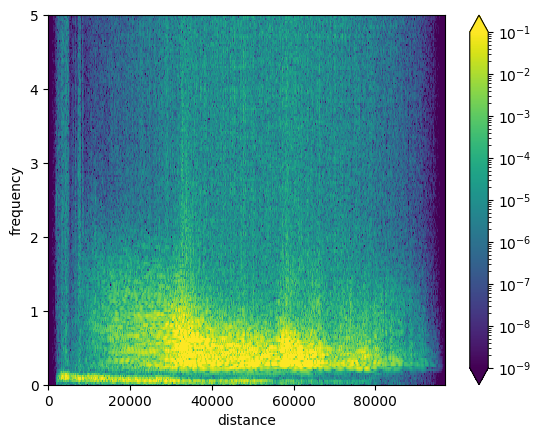

In [9]:
psd_all = xs.taper(da, window='hann', dim="distance")
psd_all = xs.taper(psd_all, window='hann', dim="time")
psd_all = xfft.rfft(psd_all, dim={"time": "frequency"})  # rename "time" -> "frequency"
psd_all = (np.abs(psd_all))**2 / (N * fs)
psd_all.plot(vmin=1e-9, vmax=1e-1, norm=mcolors.LogNorm(vmin=1e-9, vmax=1e-1), ylim=(0, 5))

### **4. Basic example for $f-k$ filter**

From the raw strain-rate data in the $t-x$ domain is possible to see strong signals related to ocean surface gravity waves, between 6 and 10 km, and Rayleigh/Scholte waves from microseismes that traverses the array quickly and are amplified by small-scale basin structures across the shelf, between 20 and 50 km:

In [ ]:
#Converting the UTC time coordinate to scalars:
time_vals = pd.to_datetime(da.coords['time'].values)
start_time = time_vals[0]
time_in_seconds = (time_vals - start_time).total_seconds()
da = da.assign_coords(time=time_in_seconds)

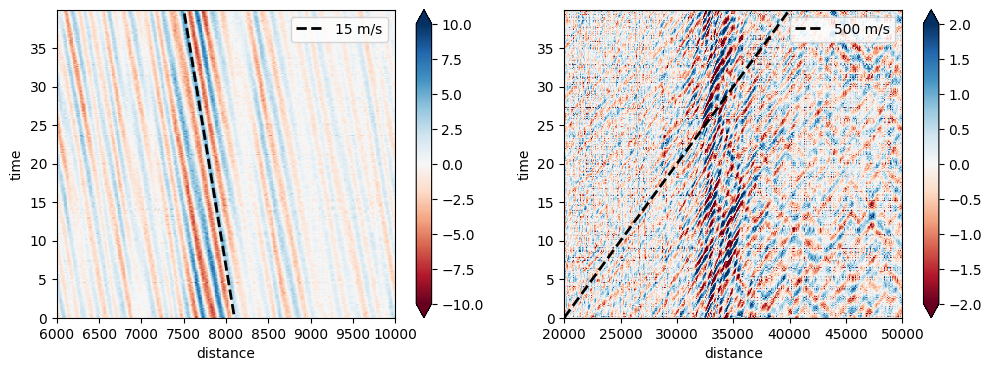

In [11]:
d1 = np.linspace(6000, 10000, 10)
d2 = np.linspace(20000, 50000, 10)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

da1 = da.plot(ax=axs[0], vmin=-10, vmax=10, cmap='RdBu')
axs[0].plot(d1, d1/(-15)+540, color='black', linestyle='--', linewidth=2, label='15 m/s')
axs[0].set_xlim(6000, 10000)
axs[0].set_ylim(time_in_seconds[0], time_in_seconds[-1])
axs[0].legend()
da2 = da.plot(ax=axs[1], vmin=-2, vmax=2, cmap='RdBu')
axs[1].plot(d2, d2/(500)-40, color='black', linestyle='--', linewidth=2, label='500 m/s')
axs[1].set_xlim(20000, 50000)
axs[1].set_ylim(time_in_seconds[0], time_in_seconds[-1])
axs[1].legend()

plt.show()

Here how to compute a FK diagram. Note that the DataArray object can be used to represent any number and kind of dimensions:

In [12]:
fk = da
fk = xs.taper(fk, dim="distance")
fk = xs.taper(fk, dim="time")
fk = xfft.rfft(fk, dim={"time": "frequency"})      # rename "time" -> "frequency"
fk = xfft.fft(fk, dim={"distance": "wavenumber"})  # rename "distance" -> "wavenumber"
fk_amp_db = 20 * np.log10(np.abs(fk))              # amplitude spectrum in dB

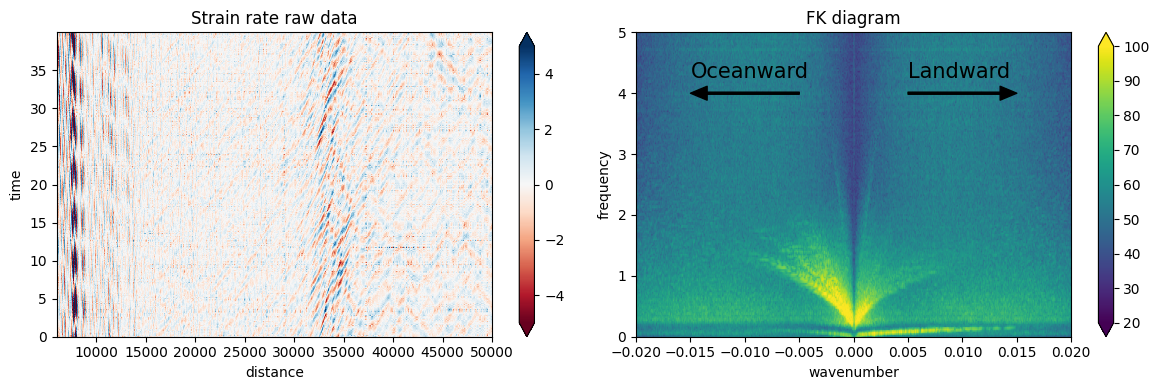

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

da1 = da.plot(ax=axs[0], vmin=-5, vmax=5, cmap='RdBu')
axs[0].set_xlim(6000, 50000)
axs[0].set_ylim(time_in_seconds[0], time_in_seconds[-1])
axs[0].set_title('Strain rate raw data')

fks = fk_amp_db.plot(interpolation='antialiased', ax=axs[1], vmin=20, vmax=100)
axs[1].set_xlim(-0.02, 0.02)
axs[1].set_ylim(0, 5)
axs[1].set_title('FK diagram')
axs[1].annotate('Landward', xy=(0.0025, 4.25), xytext=(0.005, 4.25), fontsize=15)
axs[1].annotate('', xy=(0.015, 4), xytext=(0.005, 4), arrowprops=dict(facecolor='black', width=1.5, headwidth=10))
axs[1].annotate('Oceanward', xy=(-0.015, 4.25), fontsize=15)
axs[1].annotate('', xy=(-0.015, 4), xytext=(-0.005, 4), arrowprops=dict(facecolor='black', width=1.5, headwidth=10))

plt.tight_layout()
plt.show()

**Ocean surface gravity wave** detection: the fk spectrum reveals that the signal is mainly composed of two dispersive wave trains, propagating landward and oceanward. The linear gravity wave theory explained effectively the energy for very low frequencies:

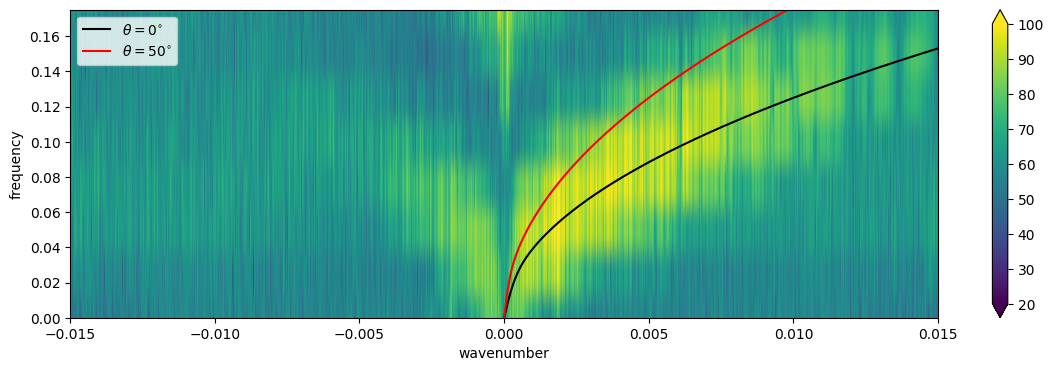

In [14]:
g = 9.81; H = 500
k = np.linspace(0, 0.015, 500)
theta2 = 60; theta2 = np.radians(theta2)
frequencies = (np.sqrt(2 * np.pi * g * k * np.tanh(H * k * 2 * np.pi))) / (2 * np.pi)
frequencies2 = (np.sqrt(2 * np.pi * g * (k / np.cos(theta2)) * np.tanh(2 * np.pi *H * k / np.cos(theta2)))) / (2 * np.pi)

fig = plt.subplots(figsize=(14, 4))
fkspectrum = fk_amp_db.plot(interpolation="antialiased", vmin=20, vmax=100, ylim=(0, 0.175), xlim=(-0.015, 0.015))
dispersioncurve1 = plt.plot(k, frequencies, color='black', label=r'$\theta=0^{\circ}$')
dispersioncurve2 = plt.plot(k, frequencies2, color='red', label=r'$\theta=50^{\circ}$')
plt.legend()
plt.show()

The dispersion curves follows the relationship of the linear gravity wave theory: $\omega = \sqrt{g*k_a*\tanh{(k_a*H)}}$, with $\omega=2\pi f$, $g=9.81 \ \text{m/s}^2$, $k_a=2\pi k$ and $H=500 \ \text{m}$ being the angular frequency, the acceleration of gravity, the angular wavenumber and the mean average of water depth, respectively. And $f, k$ are the frequency and wavenumber.

Let's say we want to isolate these wave with velocities between 10 and 50 m/s, and separate those going towards the coast versus reflecting at the coast. We can compute the $f-k$ spectrum and apply a filter that lets only the desired velocities (or frequencies or wavenumbers) through.

For isolating different type of waves, is possible to use a mute function for applying to the spectrum:

In [15]:
def _draw_polygon_win(f, k, vmin, vmax):
    """Helper routine to create a wedge-shaped 2D window

    Used by fk_filter to taper FK-transformed data around
    a given velocity range
    """

    Nk, Nf = len(k), len(f)

    # In the trivial case that vmin = -inf and vmax = inf, all the coefficients are kept
    if (vmax == np.inf) and (vmin == -np.inf):
        return np.ones((Nf, Nk))

    k_range = np.linspace(k.min(), k.max(), 1001)
    try:
        f_range_min = vmin * k_range
        f_range_max = vmax * k_range
    except RuntimeWarning:
        print(k_range)

    dir_vmin = np.sign(vmin)
    dir_vmax = np.sign(vmax)

    win = np.zeros((Nf, Nk))

    k_centre = np.argmin(np.abs(k))
    right = Nk - 1
    down = 0
    up = Nf - 1

    f_centre = np.argmin(np.abs(f))

    """ Centre point """
    r = [f_centre]
    c = [k_centre]

    """ Upper bound """

    # If vmax is zero
    if vmax == 0:
        r.append(f_centre)
        c.append(right)
    # If vmax is infinite
    elif not np.isfinite(vmax):
        r.append(up)
        r.append(up)
        c.append(k_centre)
        c.append(right)
    # If vmax is very large but finite
    elif f_range_max.max() > f.max():
        if dir_vmax > 0:
            r.append(up)
            r.append(up)
        else:
            r.append(down)
            r.append(down)
        c.append(np.argmin(np.abs(k - dir_vmax * f.max() / vmax)))
        c.append(right)
    else:
        r.append(np.argmin(np.abs(dir_vmax * f - f_range_max.max())))
        c.append(right)

    """ Lower bound """

    # If min is zero
    if vmin == 0:
        r.append(f_centre)
        c.append(right)
    # If vmin is (negative) infinite
    elif not np.isfinite(vmin):
        r.append(down)
        r.append(down)
        c.append(right)
        c.append(k_centre)
    # If vmin is very small but finite
    elif f_range_min.max() > f.max():
        if dir_vmin > 0:
            r.append(up)
            r.append(up)
        else:
            r.append(down)
            r.append(down)
        c.append(right)
        c.append(np.argmin(np.abs(k - dir_vmin * f.max() / vmin)))
    else:
        r.append(np.argmin(np.abs(dir_vmin * f - f_range_min.max())))
        c.append(right)

    """ Centre point """
    r.append(f_centre)
    c.append(k_centre)

    rr, cc = polygon(r, c)
    win[rr, cc] = 1
    win = win + np.flip(win, axis=(0, 1))

    # Smooth the edges of the taper
    win = gaussian_filter(win, sigma=30.0, mode="constant") #initialement c'était 2.0

    return win

def taper(data, window="cosine", fftbins=False, axis=None):
    """
    Apply tapering along specifed axes.

    Parameters
    ----------
    data: array
        The data to taper.
    window: float, str, tuple or iterable.
        The window to apply. If the window requires a parameter, a tuple can be passed
        (e.g. ("tukey", 0.05)). Please refer to `scipy.signal.get_window` for more
        details. If `window`can be parsed, it will be used for all axes. Otherwise, an
        iterable with one window per axis to taper must be supplied.
    fftbins: bool
        Either to apply periodic tapering (True) or symetric tapering (False).
    axis: None, int, or iterable of int.
        The axes along which the tapering must be applied. If None all axis are tapered.
        If some axis are reapeted, tapering will only be applied once.
    """
    if axis is None:
        axes = set(range(data.ndim))
    elif isinstance(axis, int):
        axes = (axis,)
    elif hasattr(axis, "__iter__"):
        axes = set(axis)
    else:
        raise ValueError("axis must be None, integer or an iterable of integer")
    try:
        sp.get_window(window, 0)
        windows = (window,) * len(axes)
    except:
        if not len(window) == len(axes):
            raise ValueError("`window` could not be parsed")
        else:
            windows = window
    out = np.copy(data)
    for window, axis in zip(windows, axes):
        out = taper_along_axis(out, window, fftbins, axis)
    return out

def taper_along_axis(data, window="cosine", fftbins=False, axis=0):
    if not isinstance(axis, int):
        raise ValueError("axis must be an integer")
    check_axis(axis, data.ndim)
    w = sp.get_window(window, data.shape[axis], fftbins=fftbins)
    w = expand_vector(w, data.ndim, axis)
    return data * w

def expand_vector(v, ndim, axis):
    check_axis(axis, ndim)
    axis = axis % ndim
    shape = [-1 if ax == axis else 1 for ax in range(ndim)]
    return v.reshape(shape)

def check_axis(axis, ndim):
    if axis < -ndim or axis >= ndim:
        raise np.AxisError(axis, ndim)

def fk_transform(data, samp, psd=True, window="cosine"):
    """Create an fk-diagram (2D FFT)

    The notation assumes that the first axis of data is the
    temporal axis, and the second one being the spatial axis,
    though the routine generally applies to any axis order.

    Parameters
    ----------
    data : 2d array
        Data to compute the FK-diagram for
    samp : tuple of size 2
        Sampling frequencies along the two axes of `data`.
        If the first axis represents time and the second axis space,
        then the units of `samp` are 1/s and 1/m, respectively.
    PSD : bool
        Whether or not to return the fk-spectrum of the data.
        If true, the spectrum will be cut along the second
        dimension, which is redundant due to symmetry.
        Default: true
    window : float, str or tuple
        Applied window before computing the FFT to reduces edge effects.
        Please refer to scipy.signal.get_window. If None, no tappering will be applied.
        Default: "cosine"

    Returns
    -------
    fk : 2d array
        The shifted Fourier transform of the data. If PSD == true,
        the fk-spectrum is returned, defined as 2 * np.log2(|F|)
    f : 1d array
        The vector of frequencies along the first axis
    k : 1d array
        The vector of frequencies along the second axis. This vector
        is cut by half if PSD == true
    """

    Nt, Nch = data.shape
    fs, ks = samp

    # If a taper is requested, apply an isotropic cosine taper
    if window is not None:
        data = taper(data, window, axis=0) #remove axis=0, it was written for the backprojection

    # FFT and shift
    fk = scipy.fft.fftshift(scipy.fft.fft2(data))
    # Frequency vectors
    k = -scipy.fft.fftshift(scipy.fft.fftfreq(Nch, 1 / ks))
    f = scipy.fft.fftshift(scipy.fft.fftfreq(Nt, 1 / fs))

    if psd:
        fk = 2 * np.log2(np.abs(fk))
        fk = fk + np.flip(fk, axis=(0, 1))
        fk = fk[Nt // 2 :]
        f = f[Nt // 2 :]

    return fk, f, k

def fk_filter(data, samp, vmin, vmax, window="cosine", spatial_axis=1):
    """Filter the data within a given velocity range

    Parameters
    ----------
    data : 2d array
        The data to be filtered. The second axis is assumed to be
        the spatial axis. The axes can be swapped by setting
        `spatial_axis = 0`.
    samp : tuple of size 2
        Sampling frequencies along the two axes of `data`.
        If the first axis represents time and the second axis space,
        then the units of `samp` are 1/s and 1/m, respectively.
    vmin, vmax : float
        Signed velocities outside of which the data are attenuated.
        Requires -np.inf <= vmin < vmax <= +np.inf
    window : float, str or tuple
        Applied window before computing the FFT to reduces edge effects.
        Please refer to scipy.signal.get_window. If None, no tappering will be applied.
        Default: "cosine"
    spatial_axis : int
        Which axis of `data` denotes the spatial axis. Default: 1

    Returns
    -------
    data_fk : 2d array
        Filtered data
    win : 2d array
        The wedge-shaped taper that was applied to the data
    """

    # If the first axis is the spatial axis, transpose input
    if spatial_axis == 0:
        data = data.T
        samp = samp[::-1]

    # Get the 2D FFT
    fk, f, k = fk_transform(data=data, samp=samp, psd=False, window=window)
    # Create a wedge-shaped taper
    win = _draw_polygon_win(f, -k, -vmax, -vmin)
    # Apply the taper and invert the FFT shift
    fk_win = scipy.fft.ifftshift(win * fk)
    # Inverse FFT
    data_fk = np.real(scipy.fft.ifft2(fk_win))

    # If the first axis is the spatial axis, transpose result
    if spatial_axis == 0:
        data_fk = data_fk.T

    return data_fk, win




def acquisition_parameters(dc):

    # Init variables
    acq_nbr, sta_name, cable_name, fiber_name  = [], [], [], []
    start, stop, fs, sps, duration, cha_name, sensitivity = [], [], [], [], [], [], []

    # Compute parameters for each acquisition
    for node in list(dc):
        for fiber in list(dc[node]):
            count = 1
            for n in range(len(dc[node][fiber])):

                da = dc[node][fiber][n]
                acq_nbr.append(count)
                sta_name.append(choose_sta_name(node) + fiber)
                cable_name.append(node)
                fiber_name.append(fiber)

                start.append(np.datetime64(da['time'][0].values))
                stop.append(np.datetime64(da['time'][-1].values))
                duration.append((da['time'][-1] - da['time'][0]) / np.timedelta64(1, 's'))
                fs.append(1/((np.datetime64(da['time'][1].values) - np.datetime64(da['time'][0].values)) / np.timedelta64(1, 's')))
                sps.append(float(da['distance'][1].values))

                start_date = np.datetime64(da['time'][0].values)
                init_folder = str(start_date).split('T')[0].replace('-', '')

                # Read the file header
                try:
                    data_path = f"/data/optodas/ABYSS/{node}/{fiber}/{init_folder}/proc/*.hdf5"
                    last_day_file = glob(data_path)[-1]
                    fr = h5py.File(last_day_file,'r')
                except:
                    data_path = f"/data/optodas/ABYSS_compressed/{node}/{fiber}/{init_folder}/comp/*.hdf5"
                    last_day_file = glob(data_path)[-1]
                    fr = h5py.File(last_day_file,'r')

                counts2rad = np.array(fr['header']['dataScale'])

                try:
                    rad2strain = 1 / np.array(fr['header']['sensitivities'])[0][0]
                except:
                    rad2strain = 1 / np.array(fr['header']['sensitivity'])

                sensitivity.append(counts2rad * rad2strain)
                cha_name.append(get_band_code(1/np.array(fr['header']['dt'])) + "N1")
                fr.close()

                count += 1

    acquisitions = pd.DataFrame({'network': 'ABYSS',
                                'loc': '00',
                                'acq_nbr': acq_nbr,
                                'cable_name': cable_name,
                                'fiber_name': fiber_name,
                                'sta_name': sta_name,
                                'channel': cha_name,
                                'start': start,
                                'stop': stop,
                                'duration': duration,
                                'fs': fs,
                                'sps': sps,
                                'sensitivity': sensitivity})

    return acquisitions

## slant-stack
def get_frequencydomain_info(data, dt, lfhf):
        """
        Parameters
        ----------
        data : 2D Array
            Array of data.
        dt : float, optional
            Sampling rate in seconds. The default is 0.1 s.
        lfhf : List
            List containing the two cutoff frequencies in Hz. The default is 0.1 and 4 Hz

        Returns
        -------
        freqpoints: Frequency axis.
        cumphase: Unwraped phase of the data.
        """

        num_ts = data.shape[1]
        data -= data.mean() # remove mean of the data

        fs = np.fft.fftfreq(num_ts,dt) # frequency
        fd_data = np.fft.rfft(data) # fft of the data
        fs_positive = fs[:fd_data.shape[1]]
        if num_ts%2==0:
            fs_positive[-1] = -1*fs_positive[-1]
        # Even number of samples: the last value returned by rfft is the Nyquist freq.
        # Odd number of samples: last value is fftfreq is the negative Nyquist frequency
        rel_indices=np.intersect1d(np.where(fs_positive>=lfhf[0])[0],np.where(fs_positive<=lfhf[1])[0])
        freq_points = fs_positive[rel_indices]
        afdm = np.matrix(fd_data[:,rel_indices])
        unwraped_phase=np.unwrap(np.angle(afdm))
        return freq_points, unwraped_phase

def do_single_freq(distance, true_phase_data, ktrials):
    """
    Parameters
    ----------
    absdist : TYPE
        List of distances (in km).
    true_phase : TYPE
        True phase of the data.
    ktrials : TYPE


    Returns
    -------
    mod_stack : TYPE
        Dispersion Image
    """
    relative_dist = distance - distance[0]
    kxmat = np.outer(ktrials, relative_dist)
    apsm = np.exp(+1j*kxmat) # Applied phase shift matrix
    tpmat = true_phase_data.reshape(len(true_phase_data),1)
    tpcm = np.exp(1j*tpmat) #True phase column matrix
    stacked_mats = np.dot(apsm,tpcm)
    mod_stack = np.abs(stacked_mats)
    return mod_stack
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    # Butterworth bandpass filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y
def maxlocal(y):
    # Function do get local maxima
    maxloc = []
    indmax = []
    maxloc.append(y[0])
    indmax.append(0)
    for i in np.arange(1,len(y)-1):
        if y[i]>y[i-1] and y[i]>=y[i+1]:
          maxloc.append(y[i])
          indmax.append(i)
    return maxloc,indmax

In [16]:
filtered_wavefield, taper = fk_filter(data=da.values, samp=(1 / dt, 1 / dx), vmin=10, vmax=50, window="cosine", spatial_axis=1)
filtered_wavefield_xdas = xd.DataArray(filtered_wavefield, coords={"time": da.coords['time'], "distance": da.coords["distance"]}, dims=("time", "distance"))

Comparison between the raw and filtered strain rate gathers:

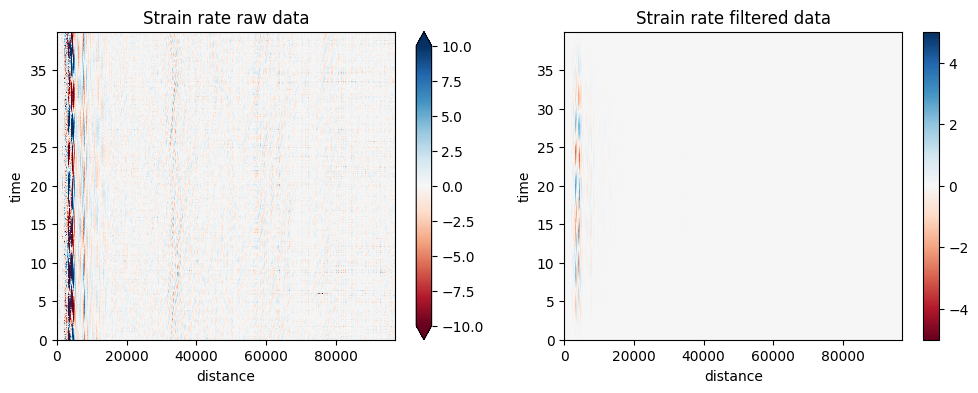

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

da1 = da.plot(ax=axs[0], vmin=-10, vmax=10, cmap='RdBu')
axs[0].set_title('Strain rate raw data')
da2 = filtered_wavefield_xdas.plot(ax=axs[1], vmin=-5, vmax=5, cmap='RdBu')
axs[1].set_title('Strain rate filtered data')

plt.show()